In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load datasets
lims_df = pd.read_csv('Rendering Plant LIMs Data Clean.csv')
production_df = pd.read_csv('Rendering Plant Production Pounds Clean.csv')
weather_df = pd.read_csv('Rendering Plant Weather Data.csv')

In [3]:
# Convert date columns to datetime format
lims_df['SAMPLED_DATE'] = pd.to_datetime(lims_df['SAMPLED_DATE'])
production_df['Posting Date'] = pd.to_datetime(production_df['Posting Date'])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

In [4]:
# Define common date range based on the available data ranges
common_start_date = '2021-05-02'
common_end_date = weather_df['DATE'].max()

In [5]:
# Filter datasets to the common date range
lims_df_filtered = lims_df[(lims_df['SAMPLED_DATE'] >= common_start_date) & (lims_df['SAMPLED_DATE'] <= common_end_date)]
production_df_filtered = production_df[(production_df['Posting Date'] >= common_start_date) & (production_df['Posting Date'] <= common_end_date)]
weather_df_filtered = weather_df[(weather_df['DATE'] >= common_start_date) & (weather_df['DATE'] <= common_end_date)]

In [6]:
# Merge the filtered datasets
merged_df = pd.merge(production_df_filtered, weather_df_filtered, left_on='Posting Date', right_on='DATE', how='left')
merged_df = pd.merge(merged_df, lims_df_filtered, left_on='Posting Date', right_on='SAMPLED_DATE', how='left')

In [14]:
# Select numeric columns and fill missing values with mean
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
merged_df[numeric_columns] = merged_df[numeric_columns].fillna(merged_df[numeric_columns].mean())

In [15]:
# Function to plot histograms
def plot_histogram(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.hist(df[column].dropna(), bins=30, alpha=0.7, color='blue')
    plt.title(f'Histogram of {title}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
# Function to plot time series data
def plot_time_series(df, date_col, value_col, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df[date_col], df[value_col], marker='o', linestyle='-', color='blue')
    plt.title(f'Time Series of {title}')
    plt.xlabel('Date')
    plt.ylabel(value_col)
    plt.grid(True)
    plt.show()

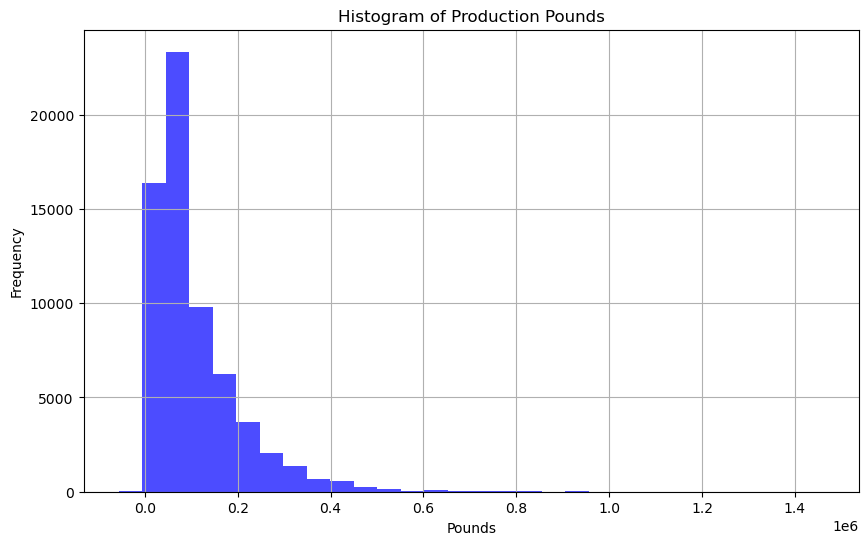

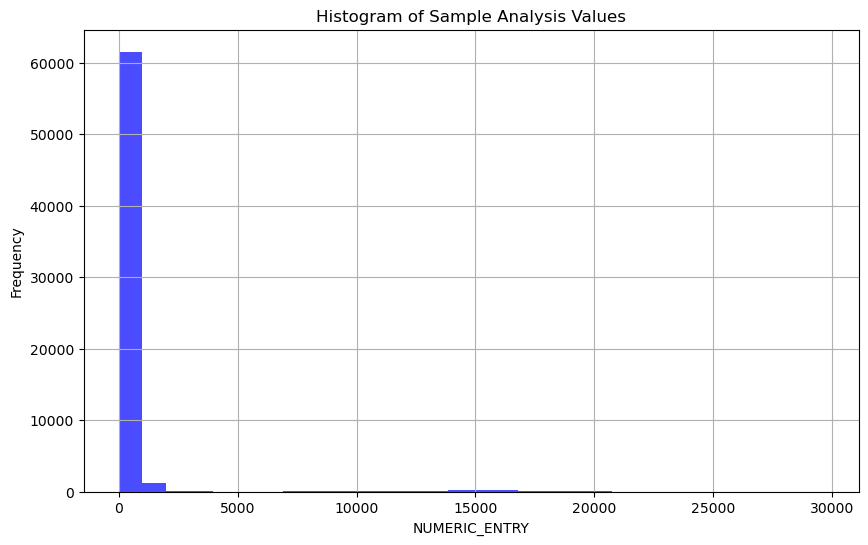

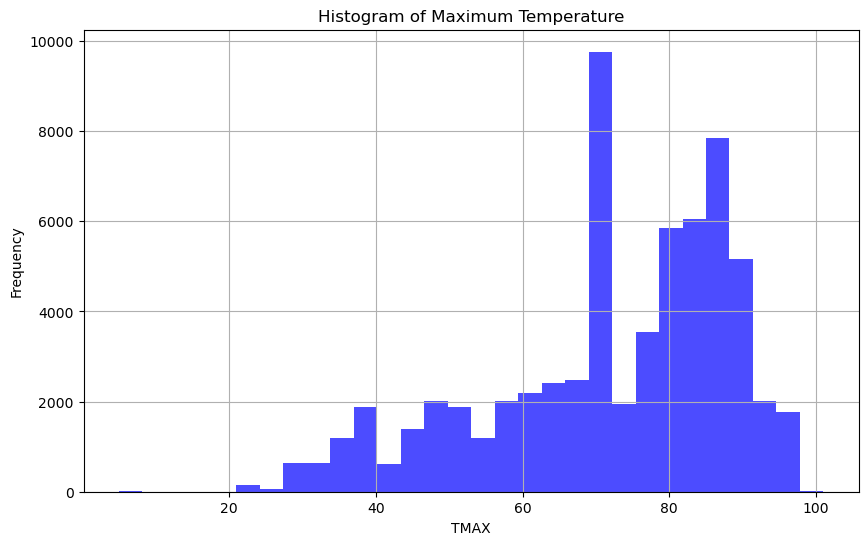

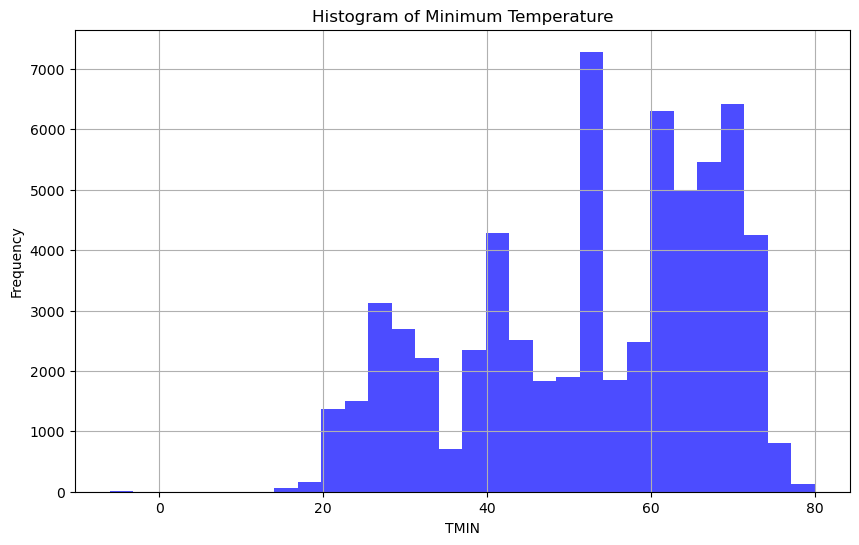

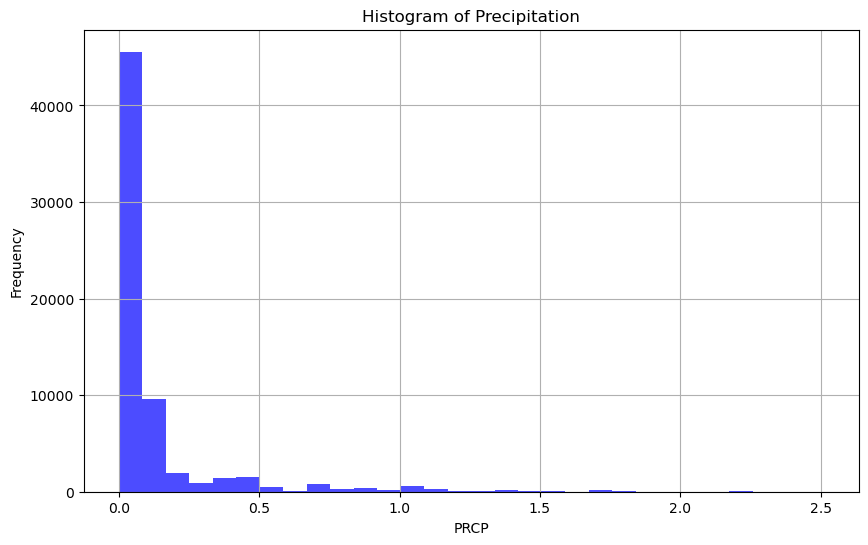

In [16]:
# Plot histograms for key variables
plot_histogram(merged_df, 'Pounds', 'Production Pounds')
plot_histogram(merged_df, 'NUMERIC_ENTRY', 'Sample Analysis Values')
plot_histogram(merged_df, 'TMAX', 'Maximum Temperature')
plot_histogram(merged_df, 'TMIN', 'Minimum Temperature')
plot_histogram(merged_df, 'PRCP', 'Precipitation')

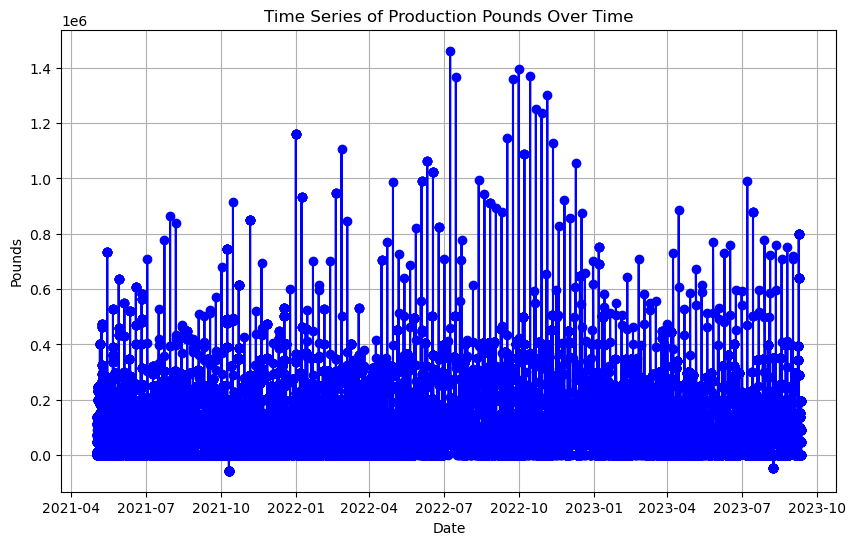

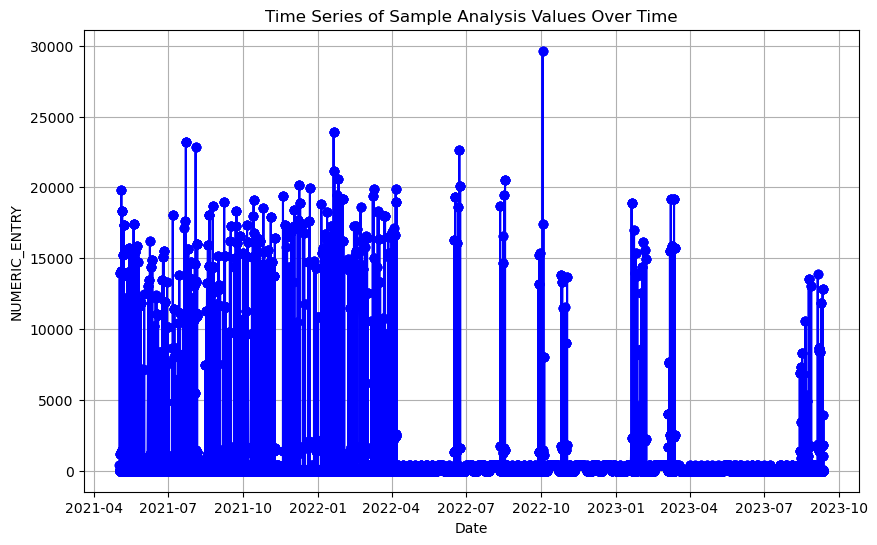

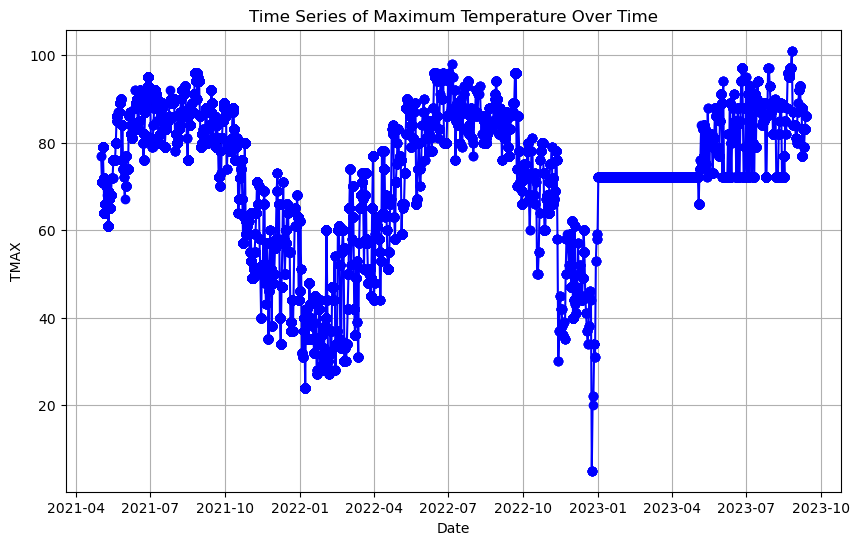

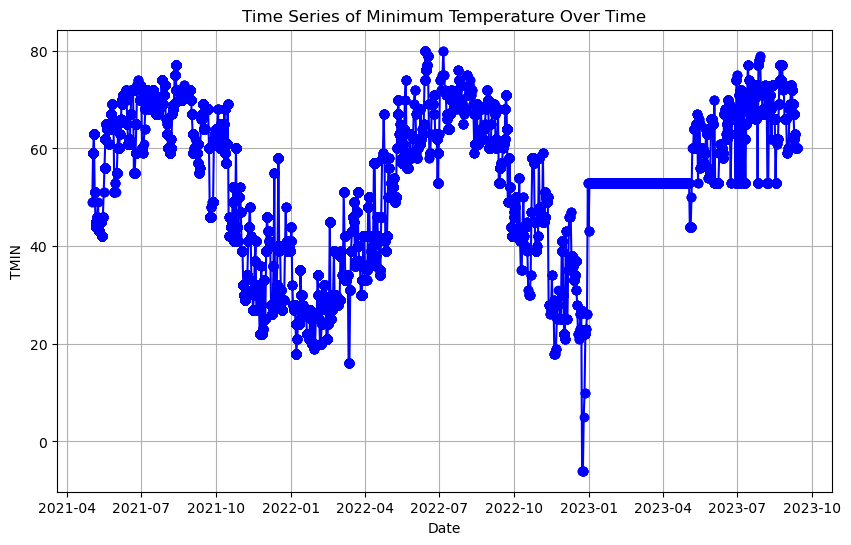

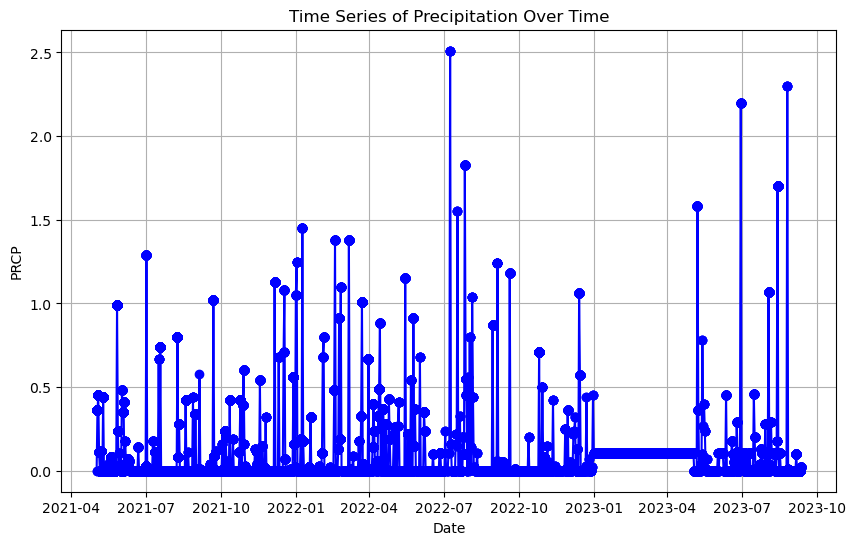

In [17]:
# Plot time series for key variables
plot_time_series(merged_df, 'Posting Date', 'Pounds', 'Production Pounds Over Time')
plot_time_series(merged_df, 'Posting Date', 'NUMERIC_ENTRY', 'Sample Analysis Values Over Time')
plot_time_series(merged_df, 'Posting Date', 'TMAX', 'Maximum Temperature Over Time')
plot_time_series(merged_df, 'Posting Date', 'TMIN', 'Minimum Temperature Over Time')
plot_time_series(merged_df, 'Posting Date', 'PRCP', 'Precipitation Over Time')

In [18]:
# Calculate correlation matrix for selected variables
correlation_columns = ['NUMERIC_ENTRY', 'Pounds', 'TMAX', 'TMIN', 'PRCP']
correlation_matrix = merged_df[correlation_columns].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
               NUMERIC_ENTRY    Pounds      TMAX      TMIN      PRCP
NUMERIC_ENTRY       1.000000  0.011542 -0.021894 -0.022388 -0.012529
Pounds              0.011542  1.000000  0.003248  0.001023  0.037754
TMAX               -0.021894  0.003248  1.000000  0.927666 -0.009663
TMIN               -0.022388  0.001023  0.927666  1.000000  0.026779
PRCP               -0.012529  0.037754 -0.009663  0.026779  1.000000


**Correlation Analysis:**

1. weak correlations between production metrics (Pounds and NUMERIC_ENTRY) and weather variables (TMAX, TMIN, PRCP).

2. correlations are very close to zero, suggesting that weather variables do not have a strong linear relationship with the production metrics.

In [19]:
# Multiple Linear Regression to predict production pounds
X = merged_df[['TMAX', 'TMIN', 'PRCP']]
y = merged_df['Pounds']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nMultiple Linear Regression Results:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Coefficients: {reg_model.coef_}")
print(f"Intercept: {reg_model.intercept_}")


Multiple Linear Regression Results:
Mean Squared Error: 9911527216.752167
R-squared: 0.0011632858134068558
Coefficients: [  176.07974277  -160.54242519 15655.03610619]
Intercept: 92874.43203217085


**Multiple Linear Regression:**

1. MSE is very high, indicating model's predictions are far from the actual values.

2. R-squared value is extremely low (0.00116), indicating that the model explains only about 0.12% of the variance in production pounds.

3. Coefficients for the weather variables (TMAX, TMIN, PRCP) are relatively small, reinforcing the conclusion that these variables have little impact on production pounds.

# Summary:
Correlation Analysis: Weather variables (temperature and precipitation) show very weak correlations with production metrics.

Regression Analysis: The multiple linear regression model indicates that weather variables do not significantly predict production pounds, as evidenced by the low R-squared value and high mean squared error.

In [20]:
# Feature engineering: Create interaction terms
merged_df['TMAX_TMIN'] = merged_df['TMAX'] * merged_df['TMIN']
merged_df['TMAX_PRCP'] = merged_df['TMAX'] * merged_df['PRCP']
merged_df['TMIN_PRCP'] = merged_df['TMIN'] * merged_df['PRCP']

In [30]:
# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[['TMAX', 'TMIN', 'PRCP', 'TMAX_TMIN', 'TMAX_PRCP', 'TMIN_PRCP']])
X = pd.DataFrame(scaled_features, columns=['TMAX', 'TMIN', 'PRCP', 'TMAX_TMIN', 'TMAX_PRCP', 'TMIN_PRCP'])
y = merged_df['Pounds']

In [31]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [35]:
# Initialize and fit different regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, solver='svd'),
    'Lasso Regression': Lasso(alpha=0.1)
}

In [36]:
# Evaluate models using cross-validation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_poly, y, cv=5, scoring='r2')
    print(f"Cross-Validation R-squared Scores: {cv_scores}")
    print(f"Average Cross-Validation R-squared Score: {cv_scores.mean()}")


Linear Regression Results:
Mean Squared Error: 9858390426.981861
R-squared: 0.006518159521152755
Cross-Validation R-squared Scores: [-0.00351332 -0.03518929 -0.04363163 -0.02386175 -0.05924402]
Average Cross-Validation R-squared Score: -0.03308799897719563

Ridge Regression Results:
Mean Squared Error: 9856138778.243034
R-squared: 0.006745070004129605
Cross-Validation R-squared Scores: [-0.00208805 -0.03484406 -0.03071721 -0.02282119 -0.01596141]
Average Cross-Validation R-squared Score: -0.021286386287312407


/Users/feyranokham/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e+14, tolerance: 5.311e+10
  model = cd_fast.enet_coordinate_descent(



Lasso Regression Results:
Mean Squared Error: 9886206723.106297
R-squared: 0.0037149650977129633


/Users/feyranokham/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e+14, tolerance: 5.543e+10
  model = cd_fast.enet_coordinate_descent(
/Users/feyranokham/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e+14, tolerance: 5.655e+10
  model = cd_fast.enet_coordinate_descent(
/Users/feyranokham/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Cross-Validation R-squared Scores: [-0.00011451 -0.04050549 -0.06790826 -0.02298136 -0.04375356]
Average Cross-Validation R-squared Score: -0.03505263708294741


/Users/feyranokham/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e+14, tolerance: 5.158e+10
  model = cd_fast.enet_coordinate_descent(


**Insights:**

R-squared Values:
All models have very low R-squared values, indicating that the models explain very little of the variance in production pounds. This suggests that weather variables are not strong predictors of production pounds in this dataset.

Cross-Validation Scores:
The negative cross-validation R-squared scores further indicate that the models do not generalize well and might even perform worse than a simple mean model on unseen data.

Convergence Warnings:
Lasso Regression shows convergence warnings, suggesting that the model did not fully converge. This could be addressed by increasing the number of iterations or adjusting the regularization parameter.